# Классификация изображений.

В этом ноутбуке будет обучаться классификатор изображений. Использован датасет по классификации emoji из тг. В нём 100 классов и около 100 картинок на каждый класс. Классы пронумерованы, кодом смайлика к которому относятся элементы класса. Скачать датасет можно вот [тут](https://disk.yandex.ru/d/elNF0DS94o2GVA).

За основу взято учебное задание с курса Прикладные задачи анализа данных, майнор Интеллектуальный анализ данных, ФКН НИУ ВШЭ

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

Задачи:

1) Как можно большее Accuracy на валидации без использования предобученных моделей и ресайза картинок. 

2) Как можно большее Accuracy на валидации с ресайзом и использованием претрейна.


Более подробный отчет о проведенных экспериментах можно найти по ссылке: https://drive.google.com/file/d/1qpCTmKgf_00bUQRiyprENIKsnTpr547z/view?usp=sharing

In [1]:
!pip install wandb

!pip3 install pytorch_lightning torchmetrics

In [2]:
# Если ниже будет не очень работать WandbLogger с первого разу, перезапустить kernel тетрадки

import wandb


wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [7]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

## Без ресайза и предобученных моделей

### Какие подходы были использованы для достижения метрики

В качестве аугментации я пробовала использовать библиотеку albumentations.

Однако, в дальнейшем я вообще отказалась от аугментаций, тк к с ними не смогла получить accuracy выше 0,136 (про это
подробнее дальше).

Первая модель, которую я написала, выглядела так, но её я не смогла запустить, потому что коллабу не хватало RAW

In [ ]:
class MyNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        # Задаю слои
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)    
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # runs the Neural Network
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 128 * 128)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

При обучении модели я столкнулась с нехваткой ресурсов в Google Collab, поэтому, чтобы облегчить обучение, сделала следующее:
1. Уменьшила размер батчей с 32 до 16
2. Использовала torch.cuda.empty_cache() модуля torch
3. Использовала Mixed Precision Training

```

trainer = pl.Trainer(
precision = "16-mixed",
max_epochs=20,
devices="auto" if torch.cuda.is_available() else None,
accelerator="gpu" if torch.cuda.is_available() else "cpu",

Python
logger=wandb_logger,
enable_progress_bar=True
)

```
4. Использовала gc.collect() чтобы избежать утечек памяти

Это всё не помогло мне запустить модель, так что я попробовала облегчить её

Код облегченной модели:

In [2]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

NameError: name 'nn' is not defined

Училось очень медленно, половина эпохи считалась 40 минут.
Попробовала учить не через trainer, а через цикл. Начало учиться быстрее, но всё ещё медленно Epoch [1/20], Loss: 3.7139
Time: 23 min.

Попробовала другую архитектуру, ResNet-34 (довольно легкая, но при этом считается эффективной)
Accuracy: 0.1360

Поменяла размер батча на 32, ничего не изменилось.

Решила взять более сложную версию архитектуры, ResNet-50, максимальная accuracy не поменялась

На этом этапе я глубоко задумалась. В итоге, решила попробовать учить без аугментации. Возможно, хотя аугментации
это и очень крутой и полезный инструмент, из-за того, что у нас несколько необычные данные и их разбиение по классам,
в нашем случае аугментация только мешала.

Resnet-50, lr = 1e-4, batch size =32 лучшее accuracy 0.2029 на 12 эпохе, так совсем чуть-чуть лучше, чем у Resnet-34

### Подготовка данных

In [8]:
## код для подтаскивания картинок
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## с гугл-диска

# data_dir_t = '/content/drive/MyDrive/Hse24/иад/домашки/train'
# data_dir_v = '/content/drive/MyDrive/Hse24/иад/домашки/val'


## с kaggle

data_dir_t = '/kaggle/input/hv2-data/train/train'
data_dir_v = '/kaggle/input/hv2-data/val/val'

folders_t = os.listdir(data_dir_t)
folders_v = os.listdir(data_dir_v)

# трансформации для картинок

train_transform = transforms.Compose([
    transforms.ToTensor()])
val_transform = transforms.Compose([
    transforms.ToTensor()])

# загрузка картинок
train_dataset = datasets.ImageFolder(root=data_dir_t, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir_v, transform=val_transform)

# DataLoader для удобной итерации по данным
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    # num_workers (int, optional) – how many subprocesses to use for data loading.
    # 0 means that the data will be loaded in the main process. (default: 0)

# чекапчик: просмотр классов
print("Классы:", train_dataset.classes)

Классы: ['U+1F232', 'U+1F306', 'U+1F31F', 'U+1F331', 'U+1F335', 'U+1F33B', 'U+1F344', 'U+1F352', 'U+1F357', 'U+1F365', 'U+1F36E', 'U+1F371', 'U+1F37D', 'U+1F37F', 'U+1F392', 'U+1F39F', 'U+1F3A3', 'U+1F3AB', 'U+1F3AD', 'U+1F3B3', 'U+1F3B9', 'U+1F3DC', 'U+1F3E1', 'U+1F3EF', 'U+1F3F3', 'U+1F400', 'U+1F401', 'U+1F402', 'U+1F40C', 'U+1F415', 'U+1F41C', 'U+1F439', 'U+1F446', 'U+1F472', 'U+1F477', 'U+1F47A', 'U+1F47C', 'U+1F484', 'U+1F487', 'U+1F489', 'U+1F48E', 'U+1F491', 'U+1F498', 'U+1F49D', 'U+1F4A0', 'U+1F4A8', 'U+1F4AD', 'U+1F4C1', 'U+1F4CE', 'U+1F4D6', 'U+1F4D7', 'U+1F4DD', 'U+1F4E2', 'U+1F4E8', 'U+1F4F1', 'U+1F4FA', 'U+1F50C', 'U+1F515', 'U+1F51D', 'U+1F529', 'U+1F52B', 'U+1F54B', 'U+1F573', 'U+1F58B', 'U+1F5B2', 'U+1F5FB', 'U+1F607', 'U+1F613', 'U+1F61E', 'U+1F626', 'U+1F62A', 'U+1F639', 'U+1F643', 'U+1F645', 'U+1F647', 'U+1F64E', 'U+1F680', 'U+1F684', 'U+1F694', 'U+1F695', 'U+1F697', 'U+1F69C', 'U+1F6A7', 'U+1F6D0', 'U+1F6E2', 'U+1F7E9', 'U+1F90E', 'U+1F91B', 'U+1F920', 'U+1F92A', '

In [10]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картинки

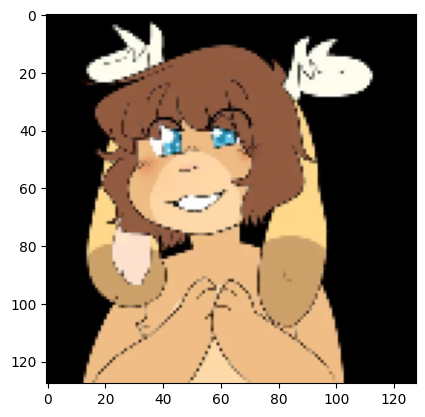

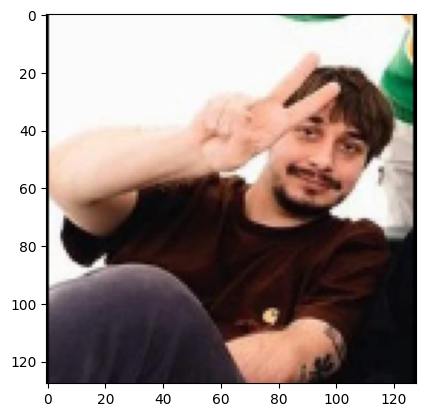

In [11]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[15].permute(1, 2, 0))
    plt.show()

    break

In [28]:
## с гугл-диска

# data_dir_t = '/content/drive/MyDrive/Hse24/иад/домашки/train'
# data_dir_v = '/content/drive/MyDrive/Hse24/иад/домашки/val'

## с kaggle

data_dir_t = '/kaggle/input/hv2-data/train/train'
data_dir_v = '/kaggle/input/hv2-data/val/val'

folders_t = os.listdir(data_dir_t)
folders_v = os.listdir(data_dir_v)

# трансформации для картинок
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()])

# загрузка картинок
train_dataset = datasets.ImageFolder(root=data_dir_t, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir_v, transform=val_transform)

In [29]:
for batch in train_dataset:
    images, labels = batch
    print(images.shape)  # output: (batch_size, 3, height, width)

    break

torch.Size([3, 128, 128])


In [14]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17
Note: you may need to restart the kernel to use updated packages.


In [15]:
## аугментация
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from albumentations.pytorch import ToTensorV2

In [17]:
seed_everything(123456)

# альбоментации для тренировочных данных

train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),

])

val_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),

])

# кастомная функция для применения альбоментаций

class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # image from (C, H, W) to (H, W, C)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label

In [18]:
# аугментация - в итоге, я не стала применять аугментацию, 
# тк с ней accuracy модели было сильно хуже. 
# думаю, дело в специфичности данных

train_aug = AlbumentationsDataset(train_dataset, transform=train_transforms)
val_aug = AlbumentationsDataset(val_dataset, transform=val_transforms) # только нормализация

In [19]:
# тесты, чтобы проверить что с размерами изображений все ок
for batch in train_aug:
    images, labels = batch
    print(images.shape)  # output: (batch_size, 3, height, width)
    break

torch.Size([3, 128, 128])


In [30]:
# создаю DataLoader
seed_everything(123456)

# c аугментацией
# train_dataloader = DataLoader(train_aug, batch_size=16, shuffle=True, num_workers=2)
# val_dataloader = DataLoader(val_aug, batch_size=16, shuffle=False, num_workers=2)

# без аугментаций
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [31]:
# тесты, чтобы проверить что с размерами изображений все ок
for batch in train_dataloader:
    images, labels = batch
    print(images.shape)  # output: (batch_size, 3, height, width)
    break

torch.Size([32, 3, 128, 128])


### Модель

In [79]:
# моя написанная руками модель. показала себя не очень, в итоге использовала не её
seed_everything(123456)

class MyNet(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def evaluate(self, dataloader, device):
        self.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total if total > 0 else 0

        return accuracy

In [16]:
## ResNet-34

import torch.nn as nn
import torch.nn.functional as F

In [64]:
seed_everything(123456)

## ResNet-34 

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet34(num_classes=1000):

    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

In [24]:
import torchvision.models as models

In [102]:
seed_everything(123456)

## ResNet-50

resnet50 = models.resnet50(weights=None) # отключила веса чтобы она была не предобученной 
num_classes = 100  
resnet50.fc = nn.Linear(in_features=resnet50.fc.in_features, out_features=num_classes)

### Тренировочный класс lightning

In [18]:
from torch.optim import Adam
import torchmetrics
import torch.utils.checkpoint
from torchmetrics import Accuracy
import pytorch_lightning as pl

In [104]:
seed_everything(123456)


class MyModule(pl.LightningModule):

    def __init__(self, model, learning_rate):
        super(MyModule, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=100)

    def forward(self, x):

        return self.model(x)

    def configure_optimizers(self):

        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        inputs, labels = train_batch
        assert images.shape[1] == 3
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, labels = val_batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

        return loss

    def train_dataloader(self):

        return train_dataloader

    def val_dataloader(self):

        return val_dataloader

In [105]:
torch.cuda.empty_cache() 

In [106]:
import gc
gc.collect()

14069

In [107]:
seed_everything(123456)

# инициализация wandb
wandb_logger = WandbLogger(
    project="lightning_logs",  
    name="ResNet50_task1_1",         
    log_model='all')

# wandb_logger = WandbLogger(log_model='all')  # Logs models, metrics, and other information
wandb.init(project="lightning_logs", name="ResNet50_task1_1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# (GPU if available, otherwise CPU)
print(device)

# model = resnet34(num_classes=100).to(device)  
# model = MyNet(num_classes=100).to(device)
model = resnet50.to(device)

module = MyModule(model=model, learning_rate=1e-4).to(device)

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆███
train_loss_epoch,█▄▁
train_loss_step,▁▁▂▂▁▁▁▄▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▂▁▁▁▁▁▄▁
trainer/global_step,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
val_accuracy,▇▁█
val_loss,▁▅█
epoch,3
train_loss_epoch,0.01194
train_loss_step,0.00158
trainer/global_step,4749
val_accuracy,0.3356


cuda


In [24]:
from tqdm import tqdm  # For progress bar

In [108]:
seed_everything(123456)

trainer = pl.Trainer(
    precision = "16-mixed",
    max_epochs=20,
    devices="auto" if torch.cuda.is_available() else None,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=wandb_logger,
    enable_progress_bar=True
)

trainer.fit(module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

### Валидация результатов задания

In [71]:
# функция оценки модели
seed_everything(123456)

def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    return accuracy

In [73]:
seed_everything(123456)

model = model
accuracy = evaluate_task(model, val_dataloader)

print(accuracy)


100%|██████████| 79/79 [00:02<00:00, 30.08it/s]


0.1968
Оценка за это задание составит 4.10 баллов


## Предобученные модели и ресайз

Учила Resnet, тк он хорошо показал себя на прошлом задании.
- Resnet-34, lr = 1e-4, batch size = 32 выбивала максимум 0,2096 на второй эпохе, потом переобучалась
- Resnet-34, lr = 1e-5, batch size = 32 выбивала максимум 0,2872 на второй эпохе, потом переобучалась (0.2836)
- Resnet-34, lr = 1e-6, batch size = 32 выбивала максимум 0,2852 на второй эпохе, потом переобучалась
- Resnet-50, lr = 1e-6, batch size = 32 accuracy 0.104 на 1 эпохе
- Resnet-50, lr = 1e-4, batch size = 32 лучше accuracy 0.3256 на 4 эпохе
- Resnet-50, lr = 1e-5, batch size = 32 первый accuracy 0.3356 на 4 эпохе

### Модель 

In [53]:
import torchvision.models as models

In [88]:
seed_everything(123456)

# предобученная resnet50
model_2 = models.resnet50(weights=True)

num_classes = 100 
model_2.fc = torch.nn.Linear(model_2.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = model_2.to(device)

### Тренировочный класс lightning

In [91]:
seed_everything(123456)

class MyModule(pl.LightningModule):

    def __init__(self, model, learning_rate):
        super(MyModule, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=100)

    def forward(self, x):

        return self.model(x)

    def configure_optimizers(self):

        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        inputs, labels = train_batch
        assert images.shape[1] == 3
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, val_batch, batch_idx):
        inputs, labels = val_batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

        return loss

    def train_dataloader(self):

        return train_dataloader

    def val_dataloader(self):

        return val_dataloader

In [98]:
seed_everything(123456)

# инициализация весов wandb
wandb_logger = WandbLogger(
    project="lightning_logs",  
    name="ResNet50_pretrained_4",         
    log_model='all')

# wandb_logger = WandbLogger(log_model='all')  # Logs models, metrics, and other information
wandb.init(project="lightning_logs", name="ResNet50_pretrained_4")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

module_2 = MyModule(model=model_2, learning_rate=1e-5).to(device)

epoch,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██
train_loss_epoch,█▃▁▁
train_loss_step,▄█▆▄▅▃█▁▇▃▃▃▄▁▁▂▃▁▄▁▄▂▁▂▁▁▁▂▂▄▁▁▁▁▆▂▁▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_accuracy,▇█▄▁
val_loss,▁▃▄█
epoch,4
train_loss_epoch,0.02544
train_loss_step,0.00423
trainer/global_step,5999
val_accuracy,0.332


cuda


In [99]:
seed_everything(123456)

trainer = pl.Trainer(
    precision = "16-mixed",
    max_epochs=20,
    devices="auto" if torch.cuda.is_available() else None,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=wandb_logger,
    enable_progress_bar=True
)

trainer.fit(module_2)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

### Валидация результатов задания

In [101]:
model_2 = model_2



accuracy = evaluate_task(model_2, val_dataloader)
print(accuracy)


100%|██████████| 79/79 [00:02<00:00, 26.71it/s]

0.3408
Оценка за это задание составит 5.00 баллов
